In [1]:
import numpy as np
import jax.numpy as jnp
from pathlib import Path
from importlib import reload

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# figure aesthetics
# plt.style.use(["../utils/dark.mplstyle","../utils/notebook.mplstyle"])  # for dark themes
# plt.style.use(["../utils/notebook.mplstyle"])  # for light theme
plt.style.use(["../utils/manuscript.mplstyle"])  # for publication

In [3]:
# custom libraries
import sys, os

sys.path.append(os.path.abspath('../../spaths'))
import spaths

sys.path.append(os.path.abspath('..'))
from utils import dmaps
from utils.mpl_utils import scale_figsize

In [4]:
cdata, cslow, cfast = 'C0', 'C1', 'C2'

# Hidden system

In [5]:
eps = 1e-3

# underlying process coefficients
def drift_sin(t, z, dz):
    x, y = z
    dz[0] = np.sin(x)
    dz[1] = (np.sin(x) - y) / eps

def dispersion_sin(t, z, dz):
    x, y = z
    dz[0,0] = np.sqrt(1 + .5*np.sin(y))
    dz[1,1] = 1.0 / np.sqrt(eps)

sde_sin2d = spaths.ItoSDE(drift_sin, dispersion_sin, noise_mixing_dim=2)

## Sample path

In [6]:
# seed setting and solver
seed = 3579
rng = np.random.default_rng(seed)
rng.integers(10**3);  # warm up of RNG

# stochastic solver
em = spaths.EulerMaruyama(rng)

In [7]:
# simulation params
dt = eps / 4
x0, y0 = 1.0, 1.0
tspan = (0.0, 200.0)

In [8]:
ens0 = np.array([[x0,y0]]) #spaths.make_ens(x0, y0)
sol_sin2d = em.solve(sde_sin2d, ens0, tspan, dt)

In [9]:
x, y = sol_sin2d.p[0].T
x = np.mod(x, 2*np.pi)
path = np.array([x, y]).T

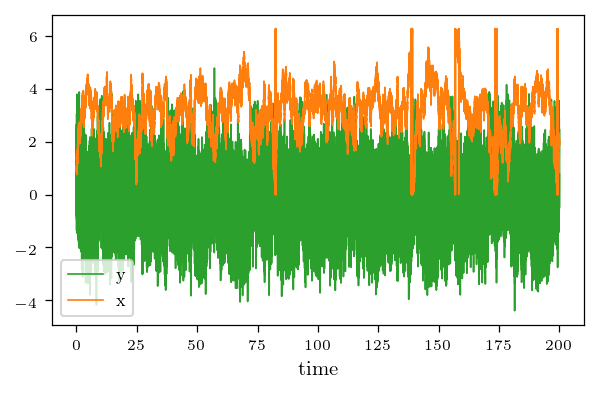

In [10]:
# path = np.fmod(sol_sin2d.p[0], [2*np.pi, np.inf])
plt.figure(figsize=scale_figsize())
plt.plot(sol_sin2d.t, path.T[1], label='y', c=cfast)
plt.plot(sol_sin2d.t, path.T[0], label='x', c=cslow)
plt.xlabel("time")
plt.legend()
plt.show()

## Data from the hidden system

In [11]:
data = path[1::100].astype(np.float32)
print(f"{data.shape = }")
print(f"{data.dtype = }")

data.shape = (8001, 2)
data.dtype = dtype('float32')


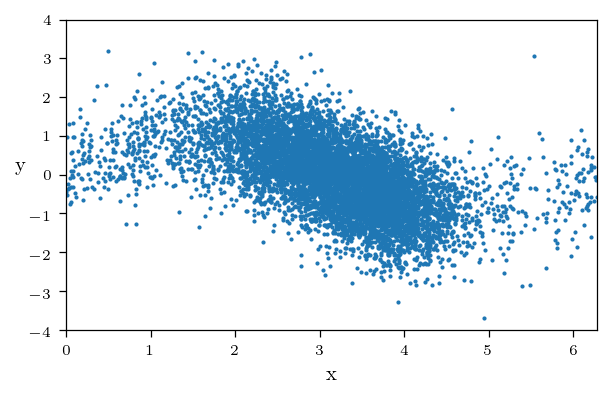

In [12]:
plt.scatter(*data.T, c=cdata)
plt.xlabel("x")
plt.ylabel("y", rotation=0)
plt.xlim([0,2*np.pi])
plt.ylim([-4,4]);

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=scale_figsize(width=4/3))

axs[0].plot(sol_sin2d.t, path.T[1], label='y', c=cfast)
axs[0].plot(sol_sin2d.t, path.T[0], label='x', c=cslow)
axs[0].set_xlabel("time")
axs[0].set_ylabel("coordinate")
axs[0].set_title("Paths of the process")
axs[0].legend()

axs[1].scatter(*data.T, c=cdata)
axs[1].set_xlabel("x")
axs[1].set_ylabel("y", rotation=0)
axs[1].set_title("Data points")
axs[1].set_xlim([0,2*np.pi])
axs[1].set_ylim([-3.5,3.5])

plt.tight_layout()
plt.savefig("Sin2D_hidden.pdf")
plt.close()

## Time-scale separation

In [13]:
# local noise covaraiances of sde at the data points
ln_covs = dmaps.lnc_ito(data, sde_sin2d)

In [14]:
e_vals, e_vecs = zip(*[np.linalg.eigh(cov) for cov in ln_covs])  # zip(*...) is equiv to transposing :)
e_vals, e_vecs = np.array(e_vals), np.array(e_vecs)

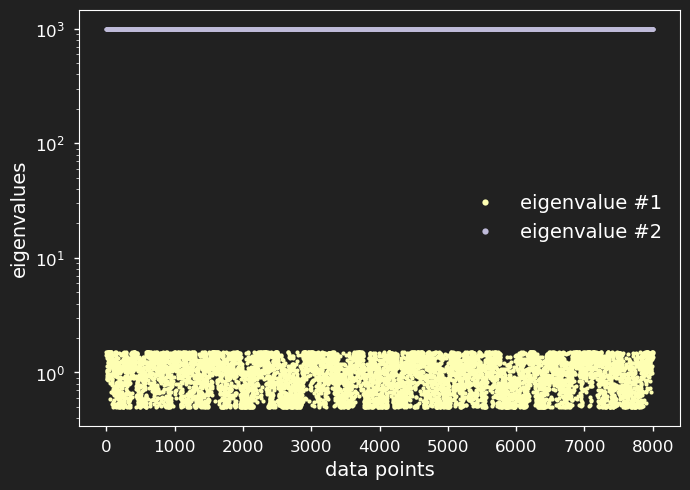

In [15]:
fig, ax = plt.subplots()
for n, (e_val, col) in enumerate(zip(e_vals.T, [cslow, cfast])):
    ax.plot(e_val, 'o', label=f"eigenvalue #{n+1}", c=col)
ax.legend()
ax.set_yscale('log')

ax.set_xlabel('data points')
ax.set_ylabel('eigenvalues')

fig.tight_layout()
plt.show(fig)
plt.close(fig)

## Short trajectories along fibers

In [16]:
data = rng.permutation(data) 

In [17]:
def plot_fibs(data, sde, tspan, dt, c=None):
    fib_paths = em.solve(sde, data, tspan, dt).p
    for fib_path in fib_paths:
        plt.scatter(*fib_path.T, s=7, c=c);

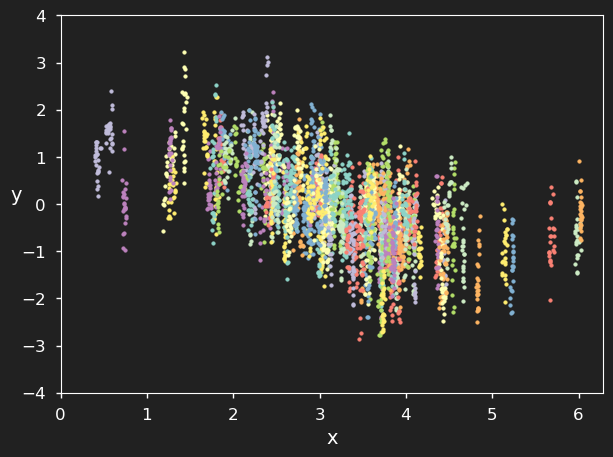

In [18]:
plot_fibs(data[::50], sde_sin2d, (0, 3*eps), dt/2)
plt.xlabel("x")
plt.ylabel("y", rotation=0)
plt.xlim([0,2*np.pi])
plt.ylim([-4,4])
plt.show()

## Sampling slow manifold

In [19]:
def plot_sman(data, sde, nreps, tspan, dt, c=None):
    ens0 = np.repeat(data, nreps, axis=0)
    nsteps = int(tspan[1]/dt)
    bursts = em.burst(sde, ens0, (0, nsteps), dt).reshape(len(data), nreps, 2)
    slow_means = np.nanmean(bursts, axis=1)
    plt.scatter(*slow_means.T, c=c, s=10)
    
    return slow_means

In [20]:
nreps = 250

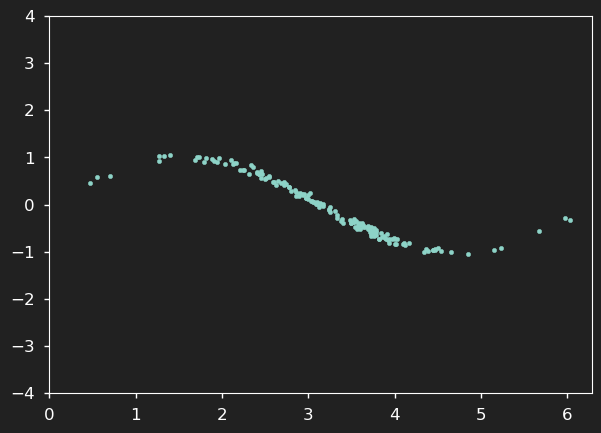

In [21]:
plot_sman(data[::50], sde_sin2d, nreps, (0, 3*eps), dt/2)
plt.xlim([0,2*np.pi])
plt.ylim([-4,4])
plt.show()

## A complete picture

In [22]:
n_fibs = 100
x_start = rng.choice(data[:, 0], size=n_fibs)
y_start = np.array([2*(-1)**n for n in range(n_fibs)])

In [23]:
fibs_ens0 = np.array([x_start, y_start]).T
fibs_ens0.shape

(100, 2)

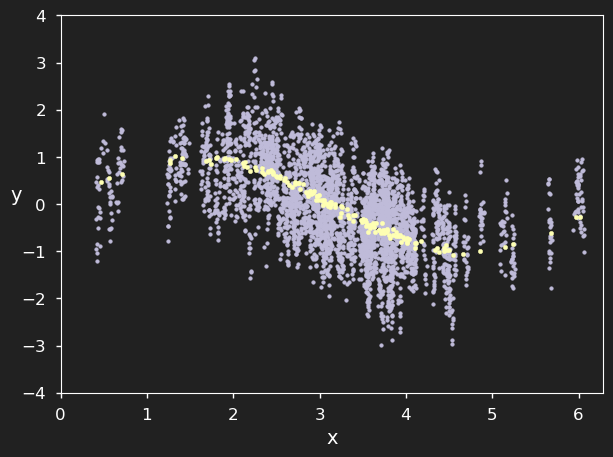

In [24]:
plot_fibs(data[::50], sde_sin2d, (0, 3*eps), dt/2, c=cfast)
plot_sman(data[::50], sde_sin2d, nreps, (0, 3*eps), dt/2, c=cslow)
plt.xlabel("x")
plt.ylabel("y", rotation=0)
plt.xlim([0,2*np.pi])
plt.ylim([-4,4])
plt.show()

# Observed system

In [25]:
# observed process coefficients
def drift_obs(t, z, dz):
    x, y = z
    dz[0] = np.sin(y) + np.cos(y)*(np.sin(x-np.sin(y))-y)/eps - np.sin(y)/(2*eps)
    dz[1] = (np.sin(x-np.sin(y))-y) / eps

def dispersion_obs(t, z, dz):
    x, y = z
    dz[0,0] = np.sqrt(1 + .5*np.sin(y))
    dz[0,1] = np.cos(y)/np.sqrt(eps)
    dz[1,1] = 1.0 / np.sqrt(eps)

sde_obs = spaths.ItoSDE(drift_obs, dispersion_obs, noise_mixing_dim=2)

In [26]:
tspan = (0, 200)

In [27]:
ens0 = np.array([[x0,y0]]) #spaths.make_ens(x0, y0)
sol_obs = em.solve(sde_obs, ens0, tspan, dt)

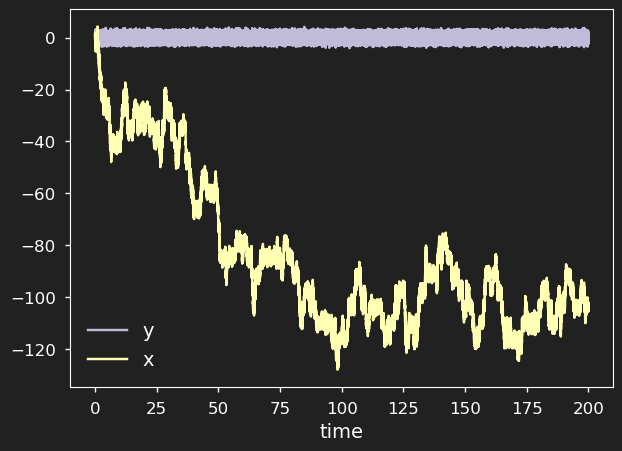

In [28]:
path = sol_obs.p[0]
plt.plot(sol_obs.t, path.T[1], label='y', c=cfast)
plt.plot(sol_obs.t, path.T[0], label='x', c=cslow)
plt.xlabel("time")
plt.legend()
plt.show()

In [29]:
x, y = sol_obs.p[0].T
x = np.mod(x, 2*np.pi)
path = np.array([x, y]).T

## Data from the observed system

In [30]:
data = path[1::200].astype(np.float32)
print(f"{data.shape = }")
print(f"{data.dtype = }")

data.shape = (4001, 2)
data.dtype = dtype('float32')


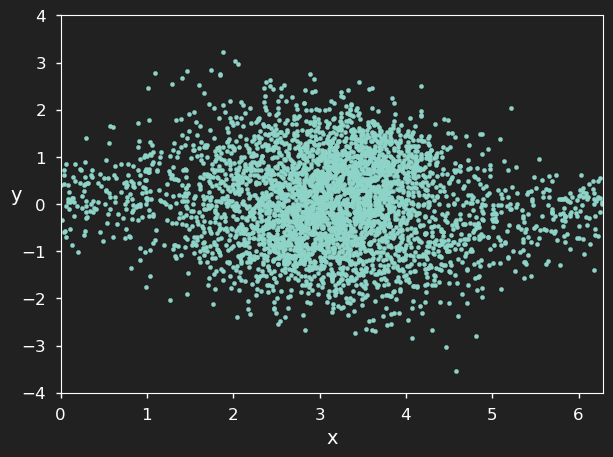

In [31]:
plt.scatter(*data.T, c=cdata);
plt.xlabel("x")
plt.ylabel("y", rotation=0)
plt.xlim([0,2*np.pi])
plt.ylim([-4,4]);

In [32]:
print(np.mean(data, axis=0))
print(np.std(data, axis=0))

[3.1237507  0.01775409]
[1.0554878  0.96434283]


## Time-scale separation

In [33]:
# local noise covaraiances of sde at the data points
ln_covs = dmaps.lnc_ito(data, sde_obs)

In [34]:
e_vals, e_vecs = zip(*[np.linalg.eigh(cov) for cov in ln_covs])  # zip(*...) is equiv to transposing :)
e_vals, e_vecs = np.array(e_vals), np.array(e_vecs)

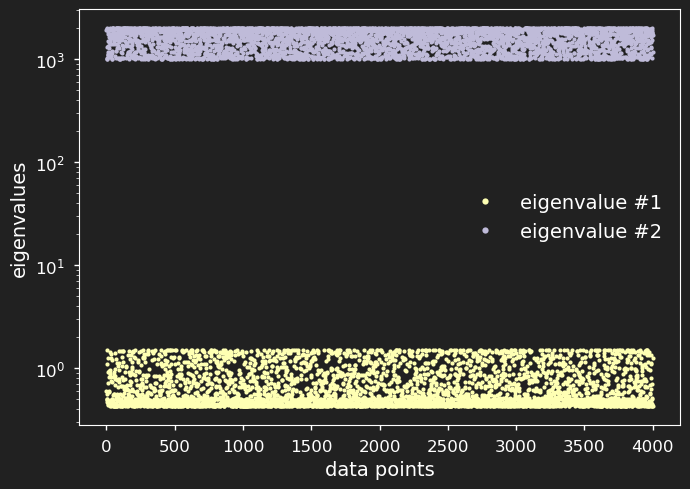

In [35]:
fig, ax = plt.subplots()
for n, (e_val, col) in enumerate(zip(e_vals.T, [cslow, cfast])):
    ax.plot(e_val, 'o', label=f"eigenvalue #{n+1}", c=col)
ax.legend()
ax.set_yscale('log')

ax.set_xlabel('data points')
ax.set_ylabel('eigenvalues')

fig.tight_layout()
plt.show(fig)
plt.close(fig)

## Short trajectories along fibers

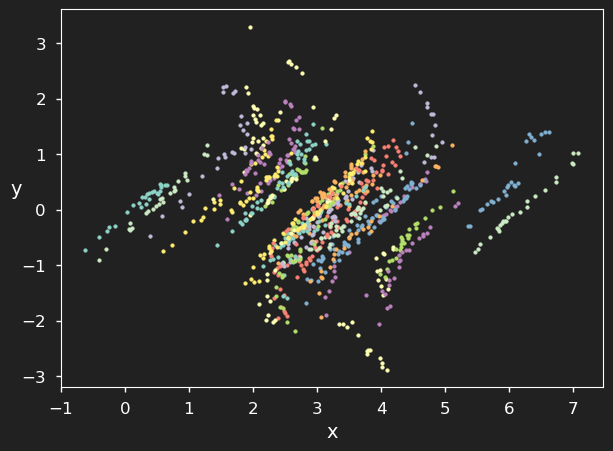

In [36]:
plot_fibs(data[::100], sde_obs, (0, 3*eps), dt/2)
plt.xlabel("x")
plt.ylabel("y", rotation=0)
plt.show()

## Sampling slow manifold

In [37]:
nreps = 250

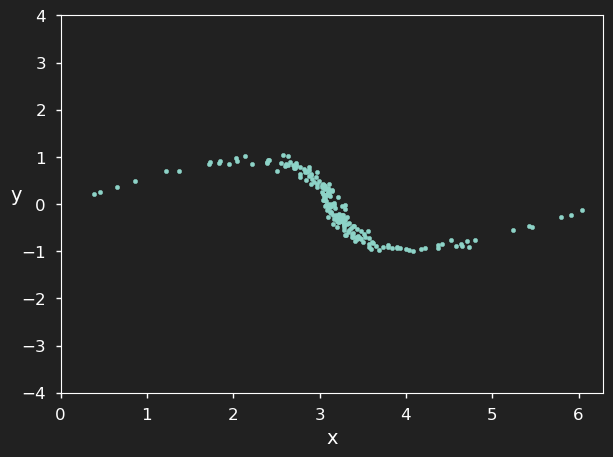

In [38]:
plot_sman(data[::20], sde_obs, nreps, (0, 3*eps), dt/2)
plt.xlabel("x")
plt.ylabel("y", rotation=0)
plt.xlim([0,2*np.pi])
plt.ylim([-4,4])
plt.show()

# Transformation

In [39]:
fwdF = lambda x: jnp.array([x[0] + jnp.sin(x[1]), x[1]])
bwdF = lambda y: jnp.array([y[0] - jnp.sin(y[1]), y[1]])

In [40]:
smap = lambda data: bwdF(data.T)[0]

In [41]:
np.allclose(bwdF(fwdF(data.T)), data.T)

True

In [42]:
Ftransform = spaths.SDETransform(fwdF, bwdF)
Fsde_sin2d = Ftransform(sde_sin2d)

In [43]:
tspan = (0, 25)

In [44]:
ens0 = np.array([[x0,y0]]) #spaths.make_ens(x0, y0)
Fsol_sin2d = em.solve(Fsde_sin2d, ens0, tspan, dt)

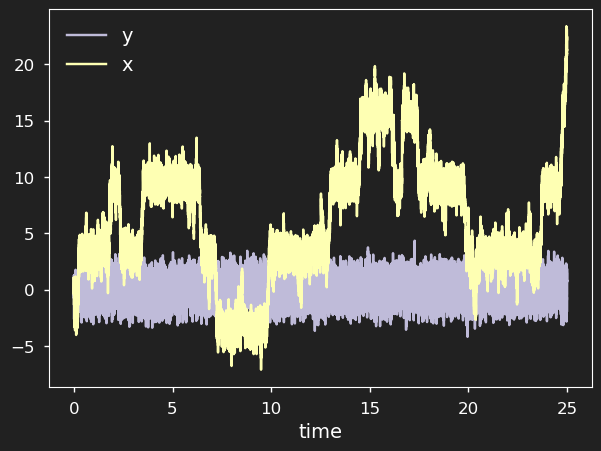

In [45]:
path = Fsol_sin2d.p[0]
plt.plot(Fsol_sin2d.t, path.T[1], label='y', c=cfast)
plt.plot(Fsol_sin2d.t, path.T[0], label='x', c=cslow)
plt.xlabel("time")
plt.legend()
plt.show()

In [46]:
x, y = Fsol_sin2d.p[0].T
x = np.mod(x, 2*np.pi)
path = np.array([x, y]).T

## Data from the observed system

In [47]:
data = path[1::20].astype(np.float32)
print(f"{data.shape = }")
print(f"{data.dtype = }")

data.shape = (5000, 2)
data.dtype = dtype('float32')


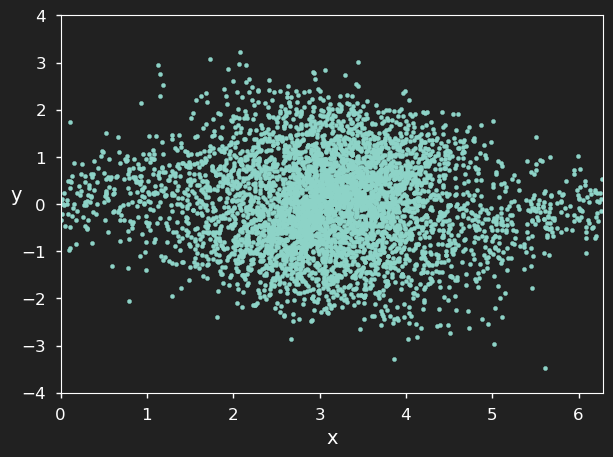

In [48]:
plt.scatter(*data.T, c=cdata);
plt.xlabel("x")
plt.ylabel("y", rotation=0)
plt.xlim([0,2*np.pi])
plt.ylim([-4,4]);

## Short trajectories along fast fibers

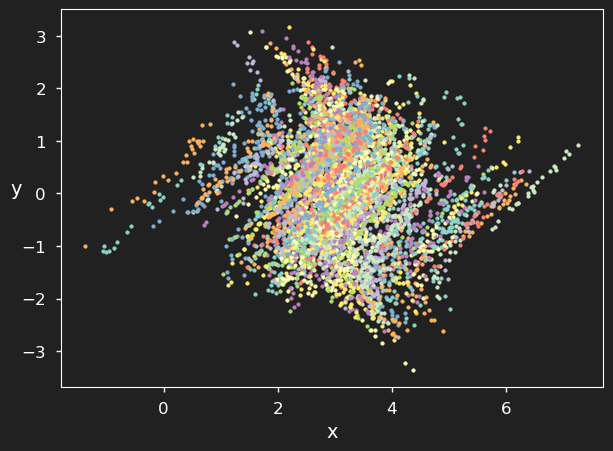

In [49]:
plot_fibs(data[::20], Fsde_sin2d, (0, 3*eps), dt/2)
plt.xlabel("x")
plt.ylabel("y", rotation=0)
plt.show()

## Sampling slow manifold

In [50]:
nreps = 250

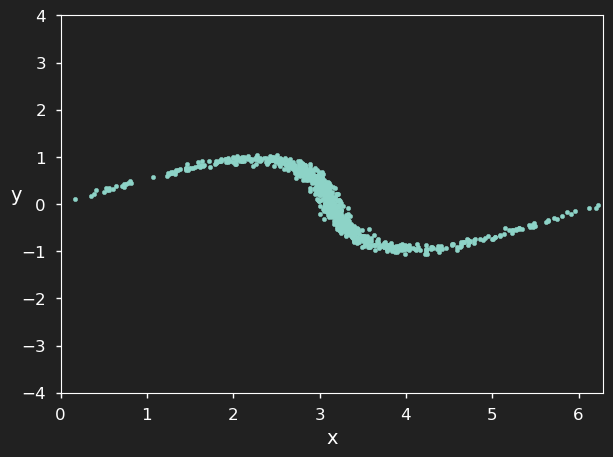

In [51]:
sdata = plot_sman(data[::5], Fsde_sin2d, nreps, (0, 3*eps), dt/2)
plt.xlabel("x")
plt.ylabel("y", rotation=0)
plt.xlim([0,2*np.pi])
plt.ylim([-4,4])
plt.show()

# Diffusion maps

In [52]:
sub_data = rng.choice(data, size=1000)

In [53]:
covs = dmaps.lnc_ito(sub_data, sde_obs)
covs.shape

(1000, 2, 2)

In [54]:
aff = dmaps.data_affinity(sub_data, covs, 1.0)

Computing affinity matrix for epsilon = 1.0 


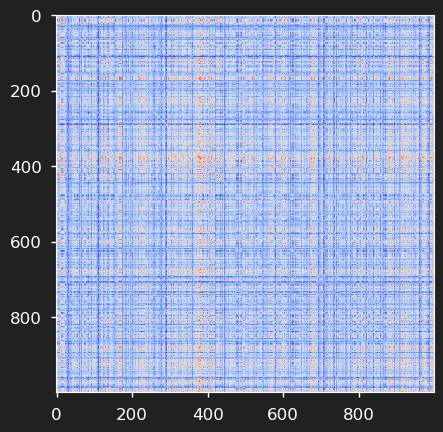

In [55]:
plt.imshow(aff);

In [56]:
from sklearn import manifold
lap_eig = manifold.SpectralEmbedding(n_components=1, affinity='precomputed')
Z = lap_eig.fit_transform(aff)
N = np.linalg.norm(Z, axis=0)
Z = Z / N

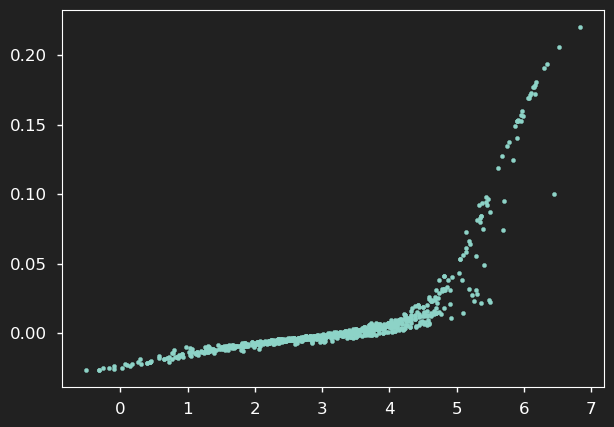

In [57]:
plt.scatter(smap(sub_data), Z);

# AEs

In [58]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from collections import OrderedDict
from pytorch_lightning import loggers as pl_loggers
from torch.utils.data import Dataset, DataLoader, random_split

In [59]:
from sf_nets.models import LightAutoencoder

ImportError: cannot import name 'LightAutoencoder' from 'sf_nets.models' (/Users/pzielinski/Code/sf_nets/sf_nets/models/__init__.py)

In [ ]:
class UnlabeledDataset(Dataset):
    
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], 0.0
        

In [ ]:
def plot_model(autoenc, data):
    with torch.no_grad():
        data_autoenc = autoenc.decoder(autoenc.encoder(torch.tensor(data, dtype=torch.float)))

    plt.plot(*data.T, '.')
    plt.plot(*data_autoenc.T, '.')
    plt.show()

In [ ]:
sdata.shape

In [ ]:
dataset2d = UnlabeledDataset(torch.tensor(sdata, dtype=torch.float))

## Training data

In [ ]:
train, valid = random_split(dataset2d, [700, 300])

In [ ]:
train_loader = DataLoader(train, batch_size=32)

In [ ]:
train_kwargs = {'max_epochs': 500,
#                 'logger': tb_logger,
#                 'checkpoint_callback': False,
                'progress_bar_refresh_rate': 100,
#                 'log_save_interval': 200,
                'deterministic': True
}

## Models -- depending on activation function used

### Tanh

In [ ]:
hid_dims_list = [ [4, 4, 2] ]

In [ ]:
ae_tanh_list = []
for hid_dims in hid_dims_list:
    ae = LightAutoencoder(2, 1, hid_dims=hid_dims, hid_act=nn.Tanh())
#     tb_logger = pl_loggers.TensorBoardLogger('tblogs/', name='my_model')
    trainer = pl.Trainer(**train_kwargs)
    trainer.fit(ae, train_loader)
    ae_tanh_list.append(ae)

In [ ]:
for ae_tanh, hid_dims in zip(ae_tanh_list, hid_dims_list):
    plt.title(f'Tanh activation, hidden dims: {hid_dims}')
    plot_model(ae_tanh, sdata)

In [ ]:
lmap = lambda data: ae.encoder(torch.from_numpy(data)).detach().numpy()

In [ ]:
s_data = smap(data)
l_data = lmap(data)

In [ ]:
plt.scatter(s_data, l_data);